In [1]:
!pip install lime gseapy pyvis networkx torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.8/590.8 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.8 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=05ee895704059de69f3e7cac66d9dc8b321f1e2f2f376286adf0673fe44c7315
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# Loader le dataset

## Télécharger le dataset depuis CBioPortal

In [9]:
import pandas as pd
import numpy as np
import os
import requests
import tarfile
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import re

print("--- Téléchargement et Extraction des Données ---")
os.makedirs("cancer_data", exist_ok=True)
mutation_url = "https://cbioportal-datahub.s3.amazonaws.com/brca_tcga_pan_can_atlas_2018.tar.gz"
tarball_path = "cancer_data/brca_tcga_data.tar.gz"
extracted_data_marker = os.path.join("cancer_data", "brca_tcga_pan_can_atlas_2018", "data_mutations.txt")

if not os.path.exists(extracted_data_marker):
    print(f"Les données ne semblent pas extraites ({extracted_data_marker} non trouvé), téléchargement...")
    try:
        response = requests.get(mutation_url, stream=True)
        response.raise_for_status()
        with open(tarball_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print("Téléchargement terminé. Extraction...")
        with tarfile.open(tarball_path, "r:gz") as tar:
            tar.extractall(path="cancer_data")
        print("Données téléchargées et extraites avec succès!")
    except requests.exceptions.RequestException as e:
        print(f"Échec du téléchargement: {e}")
    except tarfile.TarError as e:
        print(f"Échec de l'extraction: {e}")
    except Exception as e:
        print(f"Une erreur inattendue est survenue lors du téléchargement/extraction: {e}")
else:
    print("Données déjà téléchargées et extraites (vérification basique).")

--- Téléchargement et Extraction des Données ---
Données déjà téléchargées et extraites (vérification basique).


## Annotation du dataset avec MyVariant.info

In [ ]:
import pandas as pd
import numpy as np
import os
import requests
import time
import re
import concurrent.futures

BASE_DATA_PATH = "./cancer_data/brca_tcga_pan_can_atlas_2018/"
mutations_path = os.path.join(BASE_DATA_PATH, "data_mutations.txt")
output_annotated_filename = os.path.join(BASE_DATA_PATH, "mutations_annotated_myvariant_all_parallel.tsv")

print("\n--- 1. Chargement des Données de Mutations ---")
mutations_df = pd.DataFrame()
try:
    cols_to_load = ['Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position',
                    'Variant_Classification', 'Variant_Type',
                    'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2',
                    'Tumor_Sample_Barcode']

    mutations_df = pd.read_csv(mutations_path, sep="\t", comment="#", low_memory=False, usecols=lambda c: c in cols_to_load or c.startswith('dbSNP_') or c in ['SIFT', 'PolyPhen', 'IMPACT', 'Score'])
    print(f"Mutations chargées: {mutations_df.shape}")
except FileNotFoundError:
    print(f"Fichier de mutations non trouvé: {mutations_path}")
    exit()
except Exception as e:
    print(f"Erreur lors du chargement du fichier de mutations: {e}")
    try:
        print("Tentative de chargement de toutes les colonnes...")
        mutations_df = pd.read_csv(mutations_path, sep="\t", comment="#", low_memory=False)
        print(f"Mutations chargées (toutes colonnes): {mutations_df.shape}")
    except Exception as e_full:
        print(f"Échec du chargement même avec toutes les colonnes: {e_full}")
        exit()

print("\n--- 2. Préparation des Variants pour l'Annotation API ---")

if mutations_df.empty:
    print("Le DataFrame de mutations est vide. Arrêt.")
    exit()

mutations_to_annotate = mutations_df.copy()

if 'Variant_Classification' in mutations_to_annotate.columns:
    mutations_to_annotate = mutations_to_annotate[mutations_to_annotate['Variant_Classification'] == 'Missense_Mutation']
    print(f"Après filtrage 'Missense_Mutation': {mutations_to_annotate.shape}")

if 'Variant_Type' in mutations_to_annotate.columns:
    mutations_to_annotate = mutations_to_annotate[mutations_to_annotate['Variant_Type'] == 'SNP']
    print(f"Après filtrage 'Variant_Type == SNP': {mutations_to_annotate.shape}")

required_cols_for_hgvs = ['Chromosome', 'Start_Position', 'Reference_Allele', 'Tumor_Seq_Allele2']
if not all(col in mutations_to_annotate.columns for col in required_cols_for_hgvs):
    missing_cols = set(required_cols_for_hgvs) - set(mutations_to_annotate.columns)
    print(f"ERREUR: Colonnes requises pour créer l'ID HGVS manquantes: {missing_cols}. Arrêt.")
    exit()

mutations_to_annotate = mutations_to_annotate.dropna(subset=required_cols_for_hgvs).copy()
print(f"Nombre de mutations après filtrages et suppression des NaN pour HGVS: {mutations_to_annotate.shape[0]}")

if mutations_to_annotate.empty:
    print("Aucune mutation à annoter après filtrage. Arrêt.")
    exit()

def format_chrom_for_hgvs(chrom):
    chrom_str = str(chrom).replace('.0', '')
    if not chrom_str.startswith('chr'):
        return 'chr' + chrom_str
    return chrom_str

mutations_to_annotate['hgvs_id_api_query'] = mutations_to_annotate['Chromosome'].apply(format_chrom_for_hgvs) + \
                                             ':g.' + mutations_to_annotate['Start_Position'].astype(int).astype(str) + \
                                             mutations_to_annotate['Reference_Allele'].astype(str) + '>' + \
                                             mutations_to_annotate['Tumor_Seq_Allele2'].astype(str)

unique_hgvs_ids_to_query = mutations_to_annotate['hgvs_id_api_query'].unique().tolist()
print(f"Nombre de variants uniques (HGVS IDs) à annoter avec MyVariant.info: {len(unique_hgvs_ids_to_query)}")

if not unique_hgvs_ids_to_query:
    print("Aucun ID HGVS unique à interroger. Arrêt.")
    exit()

print("\n--- 3. Interrogation de l'API MyVariant.info (Appels Parallèles) ---")
all_api_responses = []
batch_size_api = 1000
MAX_WORKERS = 5

fields_to_request_api = "cadd,dbnsfp"

def fetch_batch_annotations(batch_ids_list, fields_str):
    try:
        response = requests.post('https://myvariant.info/v1/variant',
                                 json={'ids': batch_ids_list, 'fields': fields_str},
                                 timeout=90)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"   Erreur API pour un lot: {response.status_code} - {response.text[:200]}")
            return [{"query": bid, "notfound": True, "error": response.status_code} for bid in batch_ids_list]
    except requests.exceptions.RequestException as e:
        print(f"   Exception lors de la requête API pour un lot: {e}")
        return [{"query": bid, "notfound": True, "error": str(e)} for bid in batch_ids_list]


api_batches = [unique_hgvs_ids_to_query[i:i + batch_size_api] for i in range(0, len(unique_hgvs_ids_to_query), batch_size_api)]
num_total_api_batches = len(api_batches)
print(f"Nombre total de lots API à traiter: {num_total_api_batches}")

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    future_to_batch_idx = {executor.submit(fetch_batch_annotations, batch, fields_to_request_api): i for i, batch in enumerate(api_batches)}

    for i, future in enumerate(concurrent.futures.as_completed(future_to_batch_idx)):
        batch_idx = future_to_batch_idx[future]
        try:
            batch_results = future.result()
            if batch_results:
                all_api_responses.extend(batch_results)
            print(f"Lot API {batch_idx + 1}/{num_total_api_batches} traité. {len(batch_results) if batch_results else 0} réponses reçues pour ce lot.")
        except Exception as exc:
            print(f"Lot API {batch_idx + 1} a généré une exception: {exc}")

        if (i + 1) % MAX_WORKERS == 0 and i + 1 < num_total_api_batches:
            print(f"Pause après la soumission de {i+1} lots...")
            time.sleep(2)

print(f"Annotation MyVariant.info terminée. {len(all_api_responses)} réponses reçues au total.")

print("\n--- 4. Traitement des Résultats de l'API et Fusion ---")

def get_nested_value(data_dict, path_list, default=np.nan):
    current_level = data_dict
    for key in path_list:
        if isinstance(current_level, dict):
            current_level = current_level.get(key)
        else:
            return default
        if current_level is None:
            return default

    if isinstance(current_level, list):
        if not current_level:
            return default
        val = current_level[0]
        try:
            return float(val)
        except (ValueError, TypeError):
            return val
    try:
        return float(current_level)
    except (ValueError, TypeError):
        return current_level

dbnsfp_score_definitions = {
    'sift_score_api': (['sift', 'score'], np.nan),
    'sift_pred_api': (['sift', 'pred'], np.nan),
    'polyphen2_hvar_score_api': (['polyphen2', 'hvar', 'score'], np.nan),
    'polyphen2_hvar_pred_api': (['polyphen2', 'hvar', 'pred'], np.nan),
    'polyphen2_hdiv_score_api': (['polyphen2', 'hdiv', 'score'], np.nan),
    'polyphen2_hdiv_pred_api': (['polyphen2', 'hdiv', 'pred'], np.nan),
    'revel_score_api': (['revel', 'score'], np.nan),
    'metalr_score_api': (['metalr', 'score'], np.nan),
    'metalr_pred_api': (['metalr', 'pred'], np.nan),
    'metasvm_score_api': (['metasvm', 'score'], np.nan),
    'metasvm_pred_api': (['metasvm', 'pred'], np.nan),
    'mutationassessor_score_api': (['mutationassessor', 'score'], np.nan),
    'mutationassessor_pred_api': (['mutationassessor', 'pred'], np.nan),
    'mutationtaster_score_api': (['mutationtaster', 'score'], np.nan),
    'mutationtaster_pred_api': (['mutationtaster', 'pred'], np.nan),
    'provean_score_api': (['provean', 'score'], np.nan),
    'provean_pred_api': (['provean', 'pred'], np.nan),
    'fathmm_score_api': (['fathmm', 'score'], np.nan),
    'fathmm_pred_api': (['fathmm', 'pred'], np.nan),
    'fathmm_mkl_coding_score_api': (['fathmm-mkl', 'coding_score'], np.nan),
    'fathmm_mkl_coding_pred_api': (['fathmm-mkl', 'coding_pred'], np.nan),
    'm_cap_score_api': (['m-cap', 'score'], np.nan),
    'm_cap_pred_api': (['m-cap', 'pred'], np.nan),
    'deogen2_score_api': (['deogen2', 'score'], np.nan),
    'deogen2_pred_api': (['deogen2', 'pred'], np.nan),
    'mvp_score_api': (['mvp', 'score'], np.nan),
    'mpc_score_api': (['mpc', 'score'], np.nan),
    'clinpred_score_api': (['clinpred', 'score'], np.nan),
    'clinpred_pred_api': (['clinpred', 'pred'], np.nan),
    'list_s2_score_api': (['list-s2', 'score'], np.nan),
    'list_s2_pred_api': (['list-s2', 'pred'], np.nan),
    'alphamissense_score_api': (['alphamissense','score'], np.nan),
    'alphamissense_pred_api': (['alphamissense','pred'], np.nan),
    'gerp++_rs_api': (['gerp++', 'rs'], np.nan),
    'phylop100way_vertebrate_api': (['phylop', '100way_vertebrate', 'score'], np.nan),
    'phastcons100way_vertebrate_api': (['phastcons', '100way_vertebrate', 'score'], np.nan),
    'phylop17way_primate_api': (['phylop', '17way_primate', 'score'], np.nan),
    'phastcons17way_primate_api': (['phastcons', '17way_primate', 'score'], np.nan),
    'bstatistic_score_api': (['bstatistic','score'], np.nan)
}

parsed_api_annotations_list = []
if all_api_responses:
    for idx, api_result in enumerate(all_api_responses):
        if api_result.get('notfound'):
            continue

        hgvs_id_from_api = api_result.get('query', api_result.get('_id'))
        if not hgvs_id_from_api:
            continue

        annotation_dict = {'hgvs_id_api_query': hgvs_id_from_api}

        cadd_data = api_result.get('cadd', {})
        annotation_dict['CADD_phred_api'] = get_nested_value(cadd_data, ['phred'])
        annotation_dict['CADD_raw_api'] = get_nested_value(cadd_data, ['raw'])

        dbnsfp_data = api_result.get('dbnsfp', {})

        if idx == 0 and isinstance(dbnsfp_data, dict):
            print(f"\nDEBUG (API Result {idx+1}): hgvs_id: {hgvs_id_from_api}")
            print(f"   dbnsfp_data (type: {type(dbnsfp_data)}), clés de premier niveau: {list(dbnsfp_data.keys())}")
            for test_key in ['sift', 'polyphen2', 'revel', 'gerp++', 'alphamissense', 'metalr', 'mpc', 'deogen2', 'mvp']:
                if test_key in dbnsfp_data:
                    print(f"     Structure pour '{test_key}': {str(dbnsfp_data[test_key])[:200]}...")


        if isinstance(dbnsfp_data, dict):
            for score_name, (path, default_val) in dbnsfp_score_definitions.items():
                annotation_dict[score_name] = get_nested_value(dbnsfp_data, path, default_val)
        else:
            for score_name in dbnsfp_score_definitions.keys():
                annotation_dict[score_name] = np.nan

        parsed_api_annotations_list.append(annotation_dict)

    if parsed_api_annotations_list:
        api_scores_df = pd.DataFrame(parsed_api_annotations_list)
        print(f"\nDataFrame des annotations MyVariant.info créé: {api_scores_df.shape}")
        if not api_scores_df.empty:
            print(f"Colonnes dans api_scores_df (aperçu): {api_scores_df.columns.tolist()}")

        if 'hgvs_id_api_query' not in mutations_df.columns:
            print("Recréation de 'hgvs_id_api_query' sur le DataFrame mutations_df principal pour la fusion...")
            mutations_df['hgvs_id_api_query'] = mutations_df['Chromosome'].apply(format_chrom_for_hgvs) + \
                                                 ':g.' + mutations_df['Start_Position'].astype(int).astype(str) + \
                                                 mutations_df['Reference_Allele'].astype(str) + '>' + \
                                                 mutations_df['Tumor_Seq_Allele2'].astype(str)

        mutations_df_annotated = pd.merge(mutations_df, api_scores_df,
                                          on='hgvs_id_api_query',
                                          how='left')

        print(f"Taille de mutations_df_annotated après fusion: {mutations_df_annotated.shape}")

        newly_added_score_cols = [col for col in api_scores_df.columns if col != 'hgvs_id_api_query']
        for col in newly_added_score_cols:
            if col in mutations_df_annotated.columns:
                print(f"   Pour '{col}': {mutations_df_annotated[col].notnull().sum()} valeurs non nulles (annotées).")
    else:
        print("Aucune annotation n'a pu être parsée depuis les réponses de l'API.")
        mutations_df_annotated = mutations_df.copy()
else:
    print("Aucun résultat reçu de MyVariant.info. Le DataFrame original sera sauvegardé.")
    mutations_df_annotated = mutations_df.copy()

print(f"\n--- 5. Sauvegarde du Fichier Annoté ---")
try:
    os.makedirs(BASE_DATA_PATH, exist_ok=True)
    mutations_df_annotated.to_csv(output_annotated_filename, sep='\t', index=False)
    print(f"Fichier annoté sauvegardé sous: {output_annotated_filename}")
except Exception as e:
    print(f"Erreur lors de la sauvegarde du fichier annoté: {e}")

print("\n--- Script d'annotation terminé (TOUS VARIANTS, PARALLÈLE, PARSING IMBRIQUÉ AMÉLIORÉ) ---")


--- 1. Chargement des Données de Mutations ---
Mutations chargées: (130495, 16)

--- 2. Préparation des Variants pour l'Annotation API ---
Après filtrage 'Missense_Mutation': (66747, 16)
Après filtrage 'Variant_Type == SNP': (66740, 16)
Nombre de mutations après filtrages et suppression des NaN pour HGVS: 66740
Nombre de variants uniques (HGVS IDs) à annoter avec MyVariant.info: 63781

--- 3. Interrogation de l'API MyVariant.info (Appels Parallèles) ---
Nombre total de lots API à traiter: 64
Lot API 5/64 traité. 1000 réponses reçues pour ce lot.
Lot API 3/64 traité. 1000 réponses reçues pour ce lot.
Lot API 1/64 traité. 1000 réponses reçues pour ce lot.
Lot API 4/64 traité. 1000 réponses reçues pour ce lot.
Lot API 2/64 traité. 1000 réponses reçues pour ce lot.
Pause après la soumission de 5 lots...
Lot API 6/64 traité. 1000 réponses reçues pour ce lot.
Lot API 8/64 traité. 1000 réponses reçues pour ce lot.
Lot API 9/64 traité. 1000 réponses reçues pour ce lot.
Lot API 12/64 traité. 1

## Construction du dataset final annoté pour l'entraînement du modèle

In [10]:
print("--- 0. Configuration et Chemins des Fichiers ---")
BASE_DATA_PATH = "/content/cancer_data/brca_tcga_pan_can_atlas_2018/"

ANNOTATED_MUTATIONS_PATH = os.path.join(BASE_DATA_PATH, "mutations_annotated_myvariant_all_parallel.tsv")

cna_path = os.path.join(BASE_DATA_PATH, "data_cna.txt")
expression_path = os.path.join(BASE_DATA_PATH, "data_mrna_seq_v2_rsem.txt")

print("\n--- 1. Chargement des Données de Mutations Annotées ---")
mutations_df = pd.DataFrame()
if os.path.exists(ANNOTATED_MUTATIONS_PATH):
    try:
        mutations_df = pd.read_csv(ANNOTATED_MUTATIONS_PATH, sep="\t", low_memory=False)
        print(f"Mutations annotées chargées depuis '{ANNOTATED_MUTATIONS_PATH}': {mutations_df.shape}")
    except Exception as e:
        print(f"Erreur lors du chargement du fichier de mutations annotées '{ANNOTATED_MUTATIONS_PATH}': {e}")
        print("Veuillez vous assurer que le script d'annotation MyVariant.info a été exécuté avec succès et que le fichier existe.")
        exit()
else:
    print(f"Fichier de mutations annotées '{ANNOTATED_MUTATIONS_PATH}' non trouvé.")
    print("Veuillez d'abord exécuter le script 'myvariant_annotation_only_script.py' pour générer ce fichier.")
    exit()

bailey_driver_genes = [
    'ABL1', 'ACVR1', 'ACVR1B', 'ACVR2A', 'AJUBA', 'AKT1', 'ALB', 'ALK',
    'AMER1', 'APC', 'APOB', 'AR', 'ARAF', 'ARHGAP35', 'ARID1A', 'ARID2',
    'ARID5B', 'ASXL1', 'ASXL2', 'ATF7IP', 'ATM', 'ATR', 'ATRX', 'ATXN3',
    'AXIN1', 'AXIN2', 'B2M', 'BAP1', 'BCL2', 'BCL2L11', 'BCOR', 'BRAF',
    'BRCA1', 'BRCA2', 'BRD7', 'BTG2', 'CACNA1A', 'CARD11', 'CASP8',
    'CBFB', 'CBWD3', 'CCND1', 'CD70', 'CD79B', 'CDH1', 'CDK12', 'CDK4',
    'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2C', 'CEBPA', 'CHD3', 'CHD4',
    'CHD8', 'CHEK2', 'CIC', 'CNBD1', 'COL5A1', 'CREB3L3', 'CREBBP',
    'CSDE1', 'CTCF', 'CTNNB1', 'CTNND1', 'CUL1', 'CUL3', 'CYLD',
    'CYSLTR2', 'DACH1', 'DAZAP1', 'DDX3X', 'DHX9', 'DIAPH2', 'DICER1',
    'DMD', 'DNMT3A', 'EEF1A1', 'EEF2', 'EGFR', 'EGR3', 'EIF1AX', 'ELF3',
    'EP300', 'EPAS1', 'EPHA2', 'EPHA3', 'ERBB2', 'ERBB3', 'ERBB4', 'ERCC2',
    'ESR1', 'EZH2', 'FAM46D', 'FAT1', 'FBXW7', 'FGFR1', 'FGFR2', 'FGFR3',
    'FLNA', 'FLT3', 'FOXA1', 'FOXA2', 'FOXQ1', 'FUBP1', 'GABRA6', 'GATA3',
    'GNA11', 'GNA13', 'GNAQ', 'GNAS', 'GPS2', 'GRIN2D', 'GTF2I', 'H3F3A',
    'H3F3C', 'HGF', 'HIST1H1C', 'HIST1H1E', 'HLA-A', 'HLA-B', 'HRAS',
    'HUWE1', 'IDH1', 'IDH2', 'IL6ST', 'IL7R', 'INPPL1', 'IRF2', 'IRF6',
    'JAK1', 'JAK2', 'JAK3', 'KANSL1', 'KDM5C', 'KDM6A', 'KEAP1', 'KEL',
    'KIF1A', 'KIT', 'KLF5', 'KMT2A', 'KMT2B', 'KMT2C', 'KMT2D', 'KRAS',
    'KRT222', 'LATS1', 'LATS2', 'LEMD2', 'LZTR1', 'MACF1', 'MAP2K1',
    'MAP2K4', 'MAP3K1', 'MAP3K4', 'MAPK1', 'MAX', 'MECOM', 'MED12',
    'MEN1', 'MET', 'MGA', 'MGMT', 'MLH1', 'MSH2', 'MSH3', 'MSH6', 'MTOR',
    'MUC6', 'MYC', 'MYCN', 'MYD88', 'MYH9', 'NCOR1', 'NF1', 'NF2',
    'NFE2L2', 'NIPBL', 'NOTCH1', 'NOTCH2', 'NPM1', 'NRAS', 'NSD1',
    'NUP133', 'NUP93', 'PAX5', 'PBRM1', 'PCBP1', 'PDGFRA', 'PDS5B', 'PGR',
    'PHF6', 'PIK3CA', 'PIK3CB', 'PIK3CG', 'PIK3R1', 'PIK3R2', 'PIM1',
    'PLCB4', 'PLCG1', 'PLXNB2', 'PMS1', 'PMS2', 'POLE', 'POLQ', 'POLRMT',
    'PPM1D', 'PPP2R1A', 'PPP6C', 'PRKAR1A', 'PSIP1', 'PTCH1', 'PTEN',
    'PTMA', 'PTPDC1', 'PTPN11', 'PTPRC', 'PTPRD', 'RAC1', 'RAD21', 'RAF1',
    'RARA', 'RASA1', 'RB1', 'RBM10', 'RET', 'RFC1', 'RHEB', 'RHOA',
    'RHOB', 'RIT1', 'RNF111', 'RNF43', 'RPL22', 'RPL5', 'RPS6KA3',
    'RQCD1', 'RRAS2', 'RUNX1', 'RXRA', 'SCAF4', 'SETBP1', 'SETD2', 'SF1',
    'SF3B1', 'SIN3A', 'SMAD2', 'SMAD4', 'SMARCA1', 'SMARCA4', 'SMARCB1',
    'SMC1A', 'SMC3', 'SOS1', 'SOX17', 'SOX9', 'SPOP', 'SPTA1', 'SPTAN1',
    'SRSF2', 'STAG2', 'STK11', 'TAF1', 'TBL1XR1', 'TBX3', 'TCEB1', 'TCF12',
    'TCF7L2', 'TET2', 'TGFBR2', 'TGIF1', 'THRAP3', 'TLR4', 'TMSB4X',
    'TNFAIP3', 'TP53', 'TRAF3', 'TSC1', 'TSC2', 'TXNIP', 'U2AF1', 'UNCX',
    'USP9X', 'VHL', 'WHSC1', 'WT1', 'XPO1', 'ZBTB20', 'ZBTB7B', 'ZC3H12A',
    'ZCCHC12', 'ZFHX3', 'ZFP36L1', 'ZFP36L2', 'ZMYM2', 'ZMYM3', 'ZNF133',
    'ZNF750'
]
print(f"Nombre de gènes 'driver' (Bailey et al.) chargés : {len(bailey_driver_genes)}")
known_cancer_genes = set(bailey_driver_genes)

print("\n--- Chargement des Données CNA et Expression ---")

if os.path.exists(cna_path):
    try:
        print(f"Chargement de {cna_path}...")
        cna_df_raw = pd.read_csv(cna_path, sep="\t", low_memory=False)
        if 'Hugo_Symbol' in cna_df_raw.columns:
            cna_df_processed = cna_df_raw.set_index('Hugo_Symbol')
            if 'Entrez_Gene_Id' in cna_df_processed.columns:
                cna_df_processed = cna_df_processed.drop(columns=['Entrez_Gene_Id'], errors='ignore')
            cna_df_stacked = cna_df_processed.stack().reset_index()
            cna_df_stacked.columns = ['Hugo_Symbol', 'Tumor_Sample_Barcode', 'CNA_value']

            mutations_df['Hugo_Symbol'] = mutations_df['Hugo_Symbol'].astype(str)
            mutations_df['Tumor_Sample_Barcode'] = mutations_df['Tumor_Sample_Barcode'].astype(str)
            cna_df_stacked['Hugo_Symbol'] = cna_df_stacked['Hugo_Symbol'].astype(str)
            cna_df_stacked['Tumor_Sample_Barcode'] = cna_df_stacked['Tumor_Sample_Barcode'].astype(str)
            mutations_df = pd.merge(mutations_df, cna_df_stacked, on=['Hugo_Symbol', 'Tumor_Sample_Barcode'], how='left')
            print(f"  Taille de mutations_df après fusion CNA: {mutations_df.shape}")
    except Exception as e: print(f"Erreur chargement/traitement CNA: {e}")
else: print(f"Fichier CNA non trouvé: {cna_path}")

if os.path.exists(expression_path):
    try:
        print(f"Chargement de {expression_path}...")
        expression_df_raw = pd.read_csv(expression_path, sep="\t", low_memory=False)
        gene_id_col_expr = 'Hugo_Symbol'
        if gene_id_col_expr in expression_df_raw.columns:
            if 'Entrez_Gene_Id' in expression_df_raw.columns:
                expression_df_raw = expression_df_raw.drop(columns=['Entrez_Gene_Id'], errors='ignore')
            expression_df_processed = expression_df_raw.set_index(gene_id_col_expr)
            expression_df_stacked = expression_df_processed.stack().reset_index()
            expression_df_stacked.columns = ['Hugo_Symbol', 'Tumor_Sample_Barcode', 'Expression_value']
            expression_df_stacked['Expression_value'] = np.log2(pd.to_numeric(expression_df_stacked['Expression_value'], errors='coerce') + 1)

            expression_df_stacked['Hugo_Symbol'] = expression_df_stacked['Hugo_Symbol'].astype(str)
            expression_df_stacked['Tumor_Sample_Barcode'] = expression_df_stacked['Tumor_Sample_Barcode'].astype(str)
            mutations_df = pd.merge(mutations_df, expression_df_stacked, on=['Hugo_Symbol', 'Tumor_Sample_Barcode'], how='left')
            print(f"  Taille de mutations_df après fusion Expression: {mutations_df.shape}")
    except Exception as e: print(f"Erreur chargement/traitement Expression: {e}")
else: print(f"Fichier d'expression non trouvé: {expression_path}")


print("\n--- 3. Prétraitement des Mutations Final ---")
if mutations_df.empty:
    print("mutations_df est vide avant le prétraitement final. Arrêt.")
    exit()

if 'Variant_Classification' in mutations_df.columns:
    mutations_df = mutations_df[mutations_df['Variant_Classification'] == 'Missense_Mutation'].copy()
if 'Variant_Type' in mutations_df.columns:
    mutations_df = mutations_df[mutations_df['Variant_Type'] == 'SNP'].copy()
print(f"Taille de mutations_df après filtrages finaux Missense/SNP: {mutations_df.shape}")

if 'Hugo_Symbol' not in mutations_df.columns:
    print("ERREUR: Colonne 'Hugo_Symbol' non trouvée.")
    exit()

mutations_df['is_driver'] = mutations_df['Hugo_Symbol'].isin(known_cancer_genes).astype(int)
print(f"Nombre de mutations 'driver' (après tous filtrages et fusions): {mutations_df['is_driver'].sum()}")
print(f"Nombre de mutations 'non-driver': {len(mutations_df) - mutations_df['is_driver'].sum()}")

--- 0. Configuration et Chemins des Fichiers ---

--- 1. Chargement des Données de Mutations Annotées ---
Mutations annotées chargées depuis '/content/cancer_data/brca_tcga_pan_can_atlas_2018/mutations_annotated_myvariant_all_parallel.tsv': (130495, 58)
Nombre de gènes 'driver' (Bailey et al.) chargés : 299

--- Chargement des Données CNA et Expression ---
Chargement de /content/cancer_data/brca_tcga_pan_can_atlas_2018/data_cna.txt...
  Taille de mutations_df après fusion CNA: (130558, 59)
Chargement de /content/cancer_data/brca_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt...
  Taille de mutations_df après fusion Expression: (130658, 60)

--- 3. Prétraitement des Mutations Final ---
Taille de mutations_df après filtrages finaux Missense/SNP: (66826, 60)
Nombre de mutations 'driver' (après tous filtrages et fusions): 3077
Nombre de mutations 'non-driver': 63749


In [2]:
mutations_df.head()

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,dbSNP_RS,...,alphamissense_pred_api,gerp++_rs_api,phylop100way_vertebrate_api,phastcons100way_vertebrate_api,phylop17way_primate_api,phastcons17way_primate_api,bstatistic_score_api,CNA_value,Expression_value,is_driver
2,CD248,11,66082467,66082467,Missense_Mutation,SNP,C,C,T,rs373617917,...,B,2.600,-0.104,0.000,0.549,0.004,86.0,2.0,8.812967,0
5,MIPOL1,14,37838785,37838785,Missense_Mutation,SNP,A,A,G,rs756594798,...,B,2.810,3.202,1.000,-0.042,0.998,895.0,-1.0,7.602543,0
6,THSD4,15,72039337,72039337,Missense_Mutation,SNP,C,C,G,novel,...,B,4.960,3.023,1.000,0.599,0.985,944.0,0.0,13.402492,0
12,TGFB1,19,41837051,41837051,Missense_Mutation,SNP,G,G,A,rs1046906328,...,B,-0.491,0.031,0.839,0.586,0.997,779.0,0.0,9.385752,0
13,CADM4,19,44129230,44129230,Missense_Mutation,SNP,C,C,A,rs756727777,...,P,5.140,5.665,1.000,0.596,0.932,895.0,0.0,10.128536,0


In [3]:
mutations_df['Hugo_Symbol'].nunique()

15581

# Les gènes driver sont mélangés aléatoirement entre Train et Test

## Entrainement modèle


--- 4. Sélection et Prétraitement des Caractéristiques ---

Colonnes de features finales utilisées pour X: ['CNA_value', 'Expression_value', 'bstatistic_score_api', 'deogen2_score_api', 'fathmm_score_api', 'm_cap_score_api', 'mpc_score_api', 'mutationassessor_score_api', 'mvp_score_api', 'polyphen2_hdiv_score_api', 'provean_score_api']
Valeurs manquantes détectées dans les features. Imputation avec la médiane...
Imputation terminée.

--- 5. Entraînement et Évaluation du Modèle ---
Taille de l'ensemble d'entraînement: (53460, 11), (53460,)
Taille de l'ensemble de test: (13366, 11), (13366,)
Distribution des classes dans y_train: [50998  2462]
Calcul de scale_pos_weight pour XGBoost: 20.7141


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:51:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Évaluation du Modèle ---
Accuracy: 0.9339
AUC-ROC: 0.9071
AUC-PR: 0.5879

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     12751
           1       0.37      0.63      0.47       615

    accuracy                           0.93     13366
   macro avg       0.68      0.79      0.72     13366
weighted avg       0.95      0.93      0.94     13366


Confusion Matrix:
[[12095   656]
 [  228   387]]

ROC curve saved as roc_curve.png


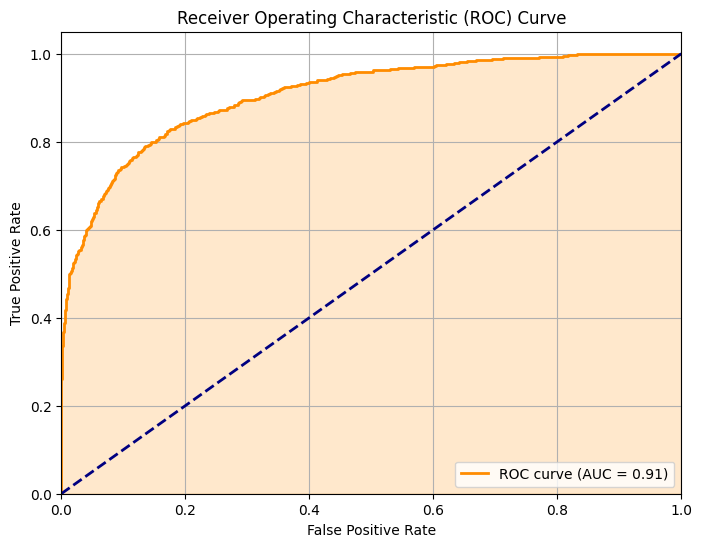

Precision-Recall curve saved as precision_recall_curve.png


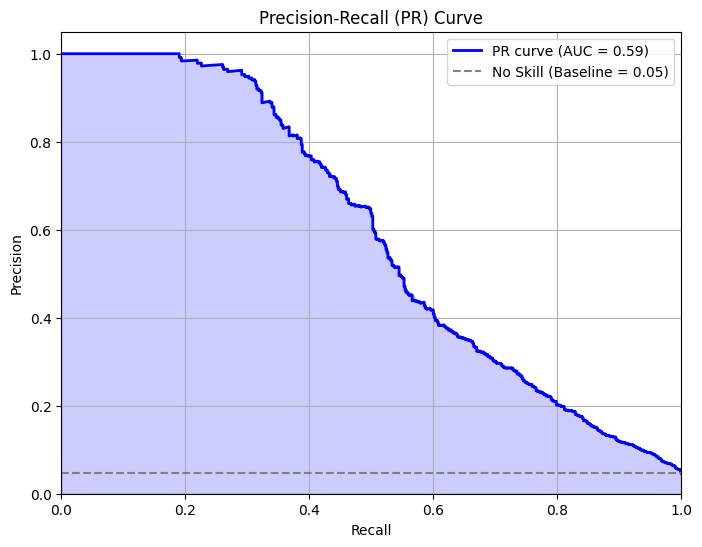


Feature Importances:
deogen2_score_api             0.151351
Expression_value              0.132198
mvp_score_api                 0.110476
mpc_score_api                 0.108249
bstatistic_score_api          0.078264
m_cap_score_api               0.075530
fathmm_score_api              0.075165
mutationassessor_score_api    0.073912
provean_score_api             0.073838
CNA_value                     0.065950
polyphen2_hdiv_score_api      0.055067
dtype: float32
Feature importances plot saved as feature_importances.png


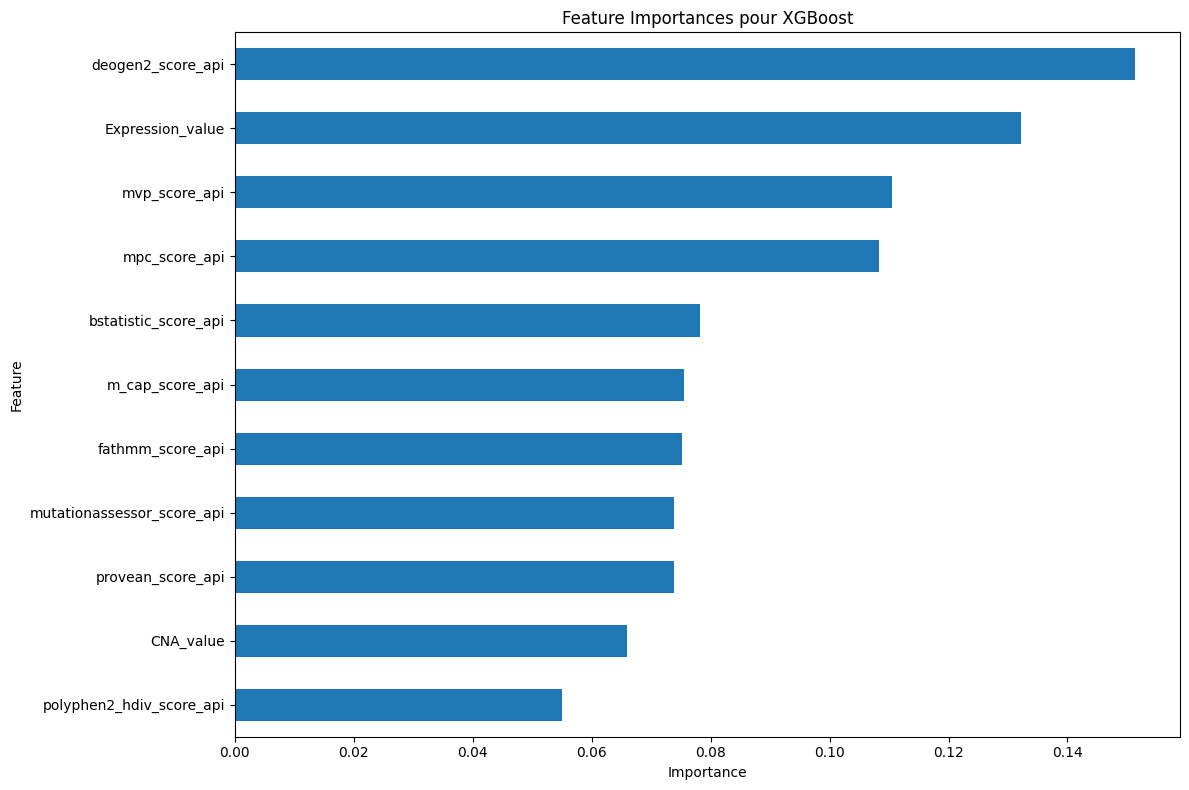

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

print("\n--- 4. Sélection et Prétraitement des Caractéristiques ---")

feature_columns = []

if 'SIFT' in mutations_df.columns:
    sift_scores_str = mutations_df['SIFT'].astype(str).apply(
        lambda x: re.search(r'\((.*?)\)', x).group(1) if pd.notna(x) and re.search(r'\((.*?)\)', x) else None)
    mutations_df['SIFT_score_maf'] = pd.to_numeric(sift_scores_str, errors='coerce')
    sift_pred_map = {'deleterious': 1, 'deleterious_low_confidence': 1, 'tolerated': 0, 'tolerated_low_confidence': 0}
    sift_pred_mapped = mutations_df['SIFT'].astype(str).apply(
        lambda x: sift_pred_map.get(x.split('(')[0].lower().strip(), pd.NA) if pd.notna(x) and '(' in x else
                  sift_pred_map.get(x.lower().strip(), pd.NA) if pd.notna(x) else pd.NA)
    mutations_df['SIFT_pred_maf'] = pd.to_numeric(sift_pred_mapped, errors='coerce')
    if not mutations_df['SIFT_score_maf'].isnull().all(): feature_columns.append('SIFT_score_maf')
    if not mutations_df['SIFT_pred_maf'].isnull().all(): feature_columns.append('SIFT_pred_maf')

if 'PolyPhen' in mutations_df.columns:
    polyphen_scores_str = mutations_df['PolyPhen'].astype(str).apply(
        lambda x: re.search(r'\((.*?)\)', x).group(1) if pd.notna(x) and re.search(r'\((.*?)\)', x) else None)
    mutations_df['PolyPhen_score_maf'] = pd.to_numeric(polyphen_scores_str, errors='coerce')
    polyphen_pred_map = {'probably_damaging': 2, 'possibly_damaging': 1, 'benign': 0, 'unknown': pd.NA}
    polyphen_pred_mapped = mutations_df['PolyPhen'].astype(str).apply(
        lambda x: polyphen_pred_map.get(x.split('(')[0].lower().strip(), pd.NA) if pd.notna(x) and '(' in x else
                  polyphen_pred_map.get(x.lower().strip(), pd.NA) if pd.notna(x) else pd.NA)
    mutations_df['PolyPhen_pred_maf'] = pd.to_numeric(polyphen_pred_mapped, errors='coerce')
    if not mutations_df['PolyPhen_score_maf'].isnull().all(): feature_columns.append('PolyPhen_score_maf')
    if not mutations_df['PolyPhen_pred_maf'].isnull().all(): feature_columns.append('PolyPhen_pred_maf')

if 'Score' in mutations_df.columns:
    mutations_df['Generic_Score_maf'] = pd.to_numeric(mutations_df['Score'], errors='coerce')
    if not mutations_df['Generic_Score_maf'].isnull().all(): feature_columns.append('Generic_Score_maf')

if 'IMPACT' in mutations_df.columns:
    impact_map = {'HIGH': 3, 'MODERATE': 2, 'LOW': 1, 'MODIFIER': 0}
    mutations_df['IMPACT_numeric_maf'] = mutations_df['IMPACT'].map(impact_map)
    if not mutations_df['IMPACT_numeric_maf'].isnull().all() : feature_columns.append('IMPACT_numeric_maf')

if 'CNA_value' in mutations_df.columns:
    mutations_df['CNA_value'] = pd.to_numeric(mutations_df['CNA_value'], errors='coerce')
    if not mutations_df['CNA_value'].isnull().all(): feature_columns.append('CNA_value')

if 'Expression_value' in mutations_df.columns:
    mutations_df['Expression_value'] = pd.to_numeric(mutations_df['Expression_value'], errors='coerce')
    if not mutations_df['Expression_value'].isnull().all(): feature_columns.append('Expression_value')

api_score_cols_to_use = [
    'CADD_phred_api', 'CADD_raw_api',
    'sift_score_api',
    'polyphen2_hvar_score_api',
    'polyphen2_hdiv_score_api',
    'revel_score_api',
    'metalr_score_api',
    'metasvm_score_api',
    'mutationassessor_score_api',
    'mutationtaster_score_api',
    'provean_score_api',
    'fathmm_score_api',
    'fathmm_mkl_coding_score_api',
    'm_cap_score_api',
    'deogen2_score_api',
    'mvp_score_api',
    'mpc_score_api',
    'clinpred_score_api',
    'list_s2_score_api',
    'alphamissense_score_api',
    'gerp++_rs_api',
    'bstatistic_score_api'
]

for col_name in api_score_cols_to_use:
    if col_name in mutations_df.columns:
        mutations_df[col_name] = pd.to_numeric(mutations_df[col_name], errors='coerce')
        if not mutations_df[col_name].isnull().all():
            feature_columns.append(col_name)
    else:
        print(f"     AVERTISSEMENT: Colonne de score API '{col_name}' attendue mais non trouvée dans mutations_df.")

feature_columns = sorted(list(set(feature_columns)))
feature_columns = [col for col in feature_columns if not "maf" in col]

sorted_by_importance = ["deogen2_score_api", "Expression_value", "mvp_score_api", "mpc_score_api", "m_cap_score_api", "provean_score_api", "fathmm_score_api", "mutationassessor_score_api", "CNA_value", "bstatistic_score_api", "polyphen2_hdiv_score_api", "gerp++_rs_api", "metalr_score_api", "clinpred_score_api", "metasvm_score_api", "list_s2_score_api", "fathmm_mkl_coding_score_api", "polyphen2_hvar_score_api", "alphamissense_score_api", "sift_score_api", "mutationtaster_score_api", "CADD_phred_api", "revel_score_api"]

top_features_candidate = sorted_by_importance

additional_features_to_consider = []
if 'Expression_value' in mutations_df.columns and 'Expression_value' not in top_features_candidate:
    additional_features_to_consider.append('Expression_value')
if 'CNA_value' in mutations_df.columns and 'CNA_value' not in top_features_candidate:
    additional_features_to_consider.append('CNA_value')

present_sorted_features = [f for f in sorted_by_importance if f in mutations_df.columns]
top_n = 11
top_features = present_sorted_features[:top_n]

if 'Expression_value' in mutations_df.columns and 'Expression_value' in feature_columns:
    if 'Expression_value' not in top_features : top_features.append('Expression_value')
if 'CNA_value' in mutations_df.columns and 'CNA_value' in feature_columns:
    if 'CNA_value' not in top_features : top_features.append('CNA_value')

top_features = [f for f in top_features if f in feature_columns]
top_features = sorted(list(set(top_features)))


print(f"\nColonnes de features finales utilisées pour X: {top_features}")

if not top_features:
    print("AVERTISSEMENT CRITIQUE : Aucune feature utilisable sélectionnée dans top_features. Arrêt.")
    exit()

X = mutations_df[top_features].copy()
y = mutations_df['is_driver'].astype(int)

if X.empty:
    print("DataFrame X (features) est vide. Arrêt.")
    exit()

if X.isnull().values.any():
    print("Valeurs manquantes détectées dans les features. Imputation avec la médiane...")
    from sklearn.impute import SimpleImputer
    X_cols_original = X.columns
    imputer = SimpleImputer(strategy='median')
    X_imputed_array = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed_array, columns=X_cols_original, index=X.index)
    print("Imputation terminée.")
    if X.isnull().values.any():
        print("ATTENTION: Encore des valeurs manquantes après imputation. Remplacement par 0...")
        X = X.fillna(0)
else:
    print("Aucune valeur manquante dans les features avant imputation.")

print("\n--- 5. Entraînement et Évaluation du Modèle ---")

if X.shape[0] < 2 or y.shape[0] < 2 or X.shape[0] != y.shape[0]:
    print("Pas assez de données ou incohérence de taille pour le split. Arrêt.")
    exit()

min_samples_per_class = 2
y_value_counts = y.value_counts()
if y_value_counts.min() < min_samples_per_class :
    print(f"AVERTISSEMENT CRITIQUE : Pas assez d'échantillons pour au moins une classe dans y (min {min_samples_per_class} requis par classe pour le split stratifié, trouvé: {y_value_counts.to_dict()}). Arrêt.")
    exit()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Taille de l'ensemble d'entraînement: {X_train.shape}, {y_train.shape}")
print(f"Taille de l'ensemble de test: {X_test.shape}, {y_test.shape}")

y_train_counts = np.bincount(y_train) if len(y_train) > 0 else np.array([0,0])

if len(y_train_counts) < 2:
    print(f"Distribution des classes dans y_train: {y_train_counts} (une seule classe présente)")
    print("AVERTISSEMENT CRITIQUE : Une seule classe est présente dans y_train après le split. Arrêt.")
    exit()
print(f"Distribution des classes dans y_train: {y_train_counts}")


if y_train_counts[0] == 0 or y_train_counts[1] == 0:
    print("AVERTISSEMENT CRITIQUE : Au moins une classe est absente ou a zéro échantillon dans y_train. Arrêt.")
    exit()
else:
    scale_pos_weight = y_train_counts[0] / y_train_counts[1]
    print(f"Calcul de scale_pos_weight pour XGBoost: {scale_pos_weight:.4f}")

model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)

if X_train.empty:
    print("X_train est vide. Impossible d'entraîner le modèle.")
else:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\n--- Évaluation du Modèle ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    auc_roc_val = -1
    auc_pr_val = -1
    precision = None
    recall = None

    if len(np.unique(y_test)) > 1:
        auc_roc_val = roc_auc_score(y_test, y_pred_proba)
        print(f"AUC-ROC: {auc_roc_val:.4f}")
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        auc_pr_val = auc(recall, precision)
        print(f"AUC-PR: {auc_pr_val:.4f}")
    else:
        print("Une seule classe présente dans y_test pour le calcul des AUC.")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    if len(np.unique(y_test)) > 1 and y_pred_proba is not None:
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc_val:.2f})')
        plt.fill_between(fpr, tpr, color='darkorange', alpha=0.2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig('roc_curve_all_genes.png')
        print("\nROC curve saved as roc_curve.png")
        plt.show()

        if precision is not None and recall is not None:
            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {auc_pr_val:.2f})')
            sorted_indices = np.argsort(recall)
            sorted_recall = recall[sorted_indices]
            sorted_precision = precision[sorted_indices]
            plt.fill_between(sorted_recall, sorted_precision, step='post', alpha=0.2, color='blue')

            no_skill = len(y_test[y_test==1]) / len(y_test) if len(y_test) > 0 else 0
            plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='gray', label=f'No Skill (Baseline = {no_skill:.2f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.ylim([0.0, 1.05])
            plt.xlim([0.0, 1.0])
            plt.title('Precision-Recall (PR) Curve')
            plt.legend(loc="best")
            plt.grid(True)
            plt.savefig('precision_recall_curve_all_genes.png')
            print("Precision-Recall curve saved as precision_recall_curve.png")
            plt.show()


    if hasattr(model, 'feature_importances_') and not X_train.empty :
        try:
            feature_importances_df = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            print("\nFeature Importances:")
            print(feature_importances_df)

            plt.figure(figsize=(12, max(8, len(X_train.columns) * 0.3)))
            feature_importances_df.plot(kind='barh')
            plt.title('Feature Importances pour XGBoost')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importances.png')
            print("Feature importances plot saved as feature_importances.png")
            plt.show()
        except Exception as e:
            print(f"Erreur lors de l'affichage/visualisation des feature importances: {e}")

## Explication LIME

In [ ]:
try:
    import lime
    import lime.lime_tabular
except ImportError:
    print("La librairie LIME n'est pas installée. Veuillez l'installer avec : pip install lime")
    exit()

try:
    from pyvis.network import Network
    import webbrowser
except ImportError:
    print("La librairie Pyvis n'est pas installée. Veuillez l'installer avec : pip install pyvis")
    exit()

import matplotlib.pyplot as plt


required_vars = ['model', 'X_train', 'X_test', 'y_test', 'mutations_df', 'y_pred_proba', 'y_pred']
for var_name in required_vars:
    if var_name not in locals() and var_name not in globals(): # Vérifie dans les variables locales et globales
        print(f"ERREUR: La variable '{var_name}' n'a pas été définie par votre script précédent. Le script LIME/Pyvis ne peut pas continuer.")
        exit()
if 'indices_test' not in locals() and 'indices_test' not in globals():
    print("INFO: La variable 'indices_test' n'est pas définie. Nous supposerons que X_test.index peut être utilisé directement pour localiser les données dans mutations_df.")
    if hasattr(X_test, 'index'):
        indices_test = X_test.index
    else:
        print(f"ERREUR: 'indices_test' n'est pas défini et X_test n'a pas d'attribut 'index'. Impossible de continuer.")
        exit()


print("\n--- 6. Explicabilité du Modèle avec LIME ---")

if not X_train.empty and not X_test.empty and y_pred_proba.size > 0:
    try:
        explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X_train.values,
            feature_names=X_train.columns.tolist(),
            class_names=['Non-Driver', 'Driver'],
            mode='classification',
            random_state=42
        )

        num_instances_to_explain = min(5, len(X_test))
        if num_instances_to_explain > 0:
            sample_df_indices = np.random.choice(X_test.index, num_instances_to_explain, replace=False)

            for i, instance_df_idx in enumerate(sample_df_indices):
                original_mutation_idx = instance_df_idx

                instance_to_explain = X_test.loc[instance_df_idx]
                true_label_val = y_test.loc[instance_df_idx]

                hugo_symbol_original = "N/A"
                if original_mutation_idx in mutations_df.index and 'Hugo_Symbol' in mutations_df.columns:
                    hugo_symbol_original = mutations_df.loc[original_mutation_idx, 'Hugo_Symbol']
                else:
                    print(f"  Avertissement: Impossible de récupérer Hugo_Symbol pour l'index {original_mutation_idx}")


                print(f"\nExplication LIME pour l'instance {i+1} (Index original: {original_mutation_idx}, Gène: {hugo_symbol_original}):")

                predicted_proba_instance = model.predict_proba(instance_to_explain.values.reshape(1, -1))[0]
                predicted_label_instance = model.predict(instance_to_explain.values.reshape(1, -1))[0]

                print(f"  Vrai label: {'Driver' if true_label_val == 1 else 'Non-Driver'}")
                print(f"  Prédiction: {'Driver' if predicted_label_instance == 1 else 'Non-Driver'} (Probabilité Driver: {predicted_proba_instance[1]:.4f})")

                try:
                    explanation = explainer.explain_instance(
                        data_row=instance_to_explain.values,
                        predict_fn=model.predict_proba,
                        num_features=10,
                        labels=(1,)
                    )

                    print("  Facteurs contribuant à la prédiction (LIME) pour la classe 'Driver':")
                    if 1 in explanation.local_exp:
                        sorted_exp = sorted(explanation.local_exp[1], key=lambda x: abs(x[1]), reverse=True)
                        for feature_idx, weight in sorted_exp:
                            print(f"    {X_train.columns[feature_idx]}: {weight:.4f}")

                    else:
                        print("    LIME n'a pas fourni d'explication spécifique pour la classe 'Driver' (cela peut arriver si la probabilité de cette classe est extrêmement faible ou pour d'autres raisons internes à LIME).")

                except Exception as e_lime_explain:
                    print(f"  Erreur durant l'appel à explainer.explain_instance pour l'instance {original_mutation_idx}: {e_lime_explain}")
        else:
            print("Pas assez de données dans X_test pour générer des explications LIME.")
    except Exception as e_lime_init:
        print(f"Erreur lors de l'initialisation de LIME ou de la préparation des données pour LIME: {e_lime_init}")
else:
    print("X_train, X_test ou y_pred_proba vide ou non défini correctement par le script précédent. Impossible de générer des explications LIME.")


print("\n--- 8. Visualisation des Voies de Signalisation avec Pyvis ---")

if y_pred_proba.size > 0 and not X_test.empty:

    results_df_test = mutations_df.loc[indices_test].copy()
    results_df_test['predicted_driver_proba'] = y_pred_proba
    results_df_test['predicted_driver_label'] = y_pred

    high_confidence_drivers = results_df_test[
        (results_df_test['predicted_driver_label'] == 1) & (results_df_test['predicted_driver_proba'] > 0.75)
    ]

    driver_genes_predicted_unique = high_confidence_drivers['Hugo_Symbol'].unique().tolist()
    print(f"Nombre de gènes 'driver' uniques prédits avec haute confiance (proba > 0.75): {len(driver_genes_predicted_unique)}")

    if driver_genes_predicted_unique:
        pathway_name = "PI3K-Akt-mTOR"
        selected_pathway_genes = [
            "PIK3CA", "PIK3R1", "PTEN", "AKT1", "AKT2", "AKT3",
            "MTOR", "RPTOR", "RICTOR", "TSC1", "TSC2", "RHEB",
            "PDPK1", "GSK3B", "FOXO1", "FOXO3", "BAD", "CREB1",
            "EIF4EBP1", "RPS6KB1", "TP53", "MDM2", "EGFR", "ERBB2", "KRAS", "BRAF", "STK11", "LKB1" # LKB1 est STK11
        ]

        pathway_edges = [
            ("EGFR", "PIK3CA"), ("ERBB2", "PIK3CA"), ("KRAS", "PIK3CA"),
            ("PIK3CA", "AKT1"), ("PIK3R1", "PIK3CA"),
            ("PTEN", "AKT1"),
            ("AKT1", "MTOR"), ("AKT1", "GSK3B"), ("AKT1", "FOXO1"), ("AKT1", "BAD"),
            ("AKT1", "TSC2"),
            ("TSC1", "TSC2"),
            ("TSC2", "RHEB"),
            ("RHEB", "MTOR"),
            ("MTOR", "EIF4EBP1"), ("MTOR", "RPS6KB1"),
            ("PDPK1", "AKT1"),
            ("TP53", "PTEN"),
            ("STK11", "TSC2")
        ]

        print(f"\nVisualisation de la voie '{pathway_name}' avec les gènes drivers prédits...")

        net = Network(notebook=False, height="800px", width="100%", cdn_resources='remote', directed=True, select_menu=True, filter_menu=True)

        for gene in selected_pathway_genes:
            color = "lightblue"
            title_text = f"Gène: {gene}"
            size = 15
            border_width = 1
            shape = 'ellipse'

            if gene in driver_genes_predicted_unique:
                proba = high_confidence_drivers[high_confidence_drivers['Hugo_Symbol'] == gene]['predicted_driver_proba'].max()
                color = "red"
                title_text += f"\n---\nPRÉDIT DRIVER\nProbabilité max: {proba:.3f}"
                size = 25 + (proba - 0.75) * 60
                border_width = 3
                shape = 'box'

            net.add_node(gene, label=gene, title=title_text, color=color, size=size, borderWidth=border_width, shape=shape)

        for source, target in pathway_edges:
            if source in selected_pathway_genes and target in selected_pathway_genes:
                edge_color = "grey"
                dashes_value = False
                title_interaction = "interaction (e.g. activation/régulation)"
                if (source == "PTEN" and target == "AKT1") or \
                   (source == "TSC2" and target == "RHEB") or \
                   (source == "AKT1" and target == "GSK3B") or \
                   (source == "STK11" and target == "TSC2" and "inhibition" in title_interaction.lower()):
                    edge_color="orange"
                    dashes_value=True
                    title_interaction = "interaction (e.g. inhibition)"
                net.add_edge(source, target, color=edge_color, dashes=dashes_value, title=title_interaction)

        net.set_options("""
        var options = {
          "physics": {
            "barnesHut": {
              "gravitationalConstant": -40000, "centralGravity": 0.2, "springLength": 120,
              "springConstant": 0.05, "damping": 0.1, "avoidOverlap": 0.5
            },
            "maxVelocity": 50, "minVelocity": 0.5,
            "solver": "barnesHut", "timestep": 0.5
          },
          "interaction": { "hover": true, "tooltipDelay": 200, "navigationButtons": true, "keyboard": true },
          "nodes": { "font": { "size": 12 } },
          "edges": { "smooth": { "type": "continuous", "roundness": 0.2 } }
        }
        """)

        pathway_graph_file = f"pathway_visualization_{pathway_name.replace(' ', '_')}.html"
        try:
            net.save_graph(pathway_graph_file)
            print(f"Graphe de la voie '{pathway_name}' sauvegardé dans : {os.path.realpath(pathway_graph_file)}")
            try:
                webbrowser.open('file://' + os.path.realpath(pathway_graph_file))
            except Exception as e_web:
                print(f"  Impossible d'ouvrir automatiquement le fichier dans le navigateur: {e_web}")
        except Exception as e_pyvis:
            print(f"Erreur lors de la création ou sauvegarde du graphe avec pyvis: {e_pyvis}")
    else:
        print("Aucun gène driver prédit avec haute confiance à visualiser sur le graphe de voie.")
else:
    print("y_pred_proba non défini ou X_test vide. Impossible de faire la visualisation des voies.")

print("\n--- Script LIME et Pyvis Terminé ---")

INFO: La variable 'indices_test' n'est pas définie. Nous supposerons que X_test.index peut être utilisé directement pour localiser les données dans mutations_df.

--- 6. Explicabilité du Modèle avec LIME ---

Explication LIME pour l'instance 1 (Index original: 99034, Gène: DSCR4):
  Vrai label: Non-Driver
  Prédiction: Non-Driver (Probabilité Driver: 0.0071)
  Facteurs contribuant à la prédiction (LIME) pour la classe 'Driver':
    Expression_value: -0.0321
    mutationassessor_score_api: 0.0168
    provean_score_api: -0.0121
    polyphen2_hdiv_score_api: 0.0112
    deogen2_score_api: -0.0100
    revel_score_api: 0.0098
    phylop17way_primate_api: -0.0090
    m_cap_score_api: -0.0084
    mpc_score_api: -0.0077
    metasvm_score_api: 0.0071

Explication LIME pour l'instance 2 (Index original: 74453, Gène: HECTD4):
  Vrai label: Non-Driver
  Prédiction: Non-Driver (Probabilité Driver: 0.0001)
  Facteurs contribuant à la prédiction (LIME) pour la classe 'Driver':
    m_cap_score_api: -0.

# Performance sur des gènes inconnus: on divise en deux les 299 gènes connus; une partie est dans le Train et une partie est dans le Test


--- 4. Sélection et Prétraitement des Caractéristiques ---

Colonnes de features finales utilisées pour X: ['CNA_value', 'Expression_value', 'bstatistic_score_api', 'deogen2_score_api', 'fathmm_score_api', 'm_cap_score_api', 'mpc_score_api', 'mutationassessor_score_api', 'mvp_score_api', 'polyphen2_hdiv_score_api', 'provean_score_api']

--- Division des données basée sur les gènes pour l'entraînement et le test ---
Nombre de gènes 'driver' pour l'entraînement: 221
Exemples de gènes drivers d'entraînement: ['TXNIP', 'KIF1A', 'BRD7', 'FBXW7', 'WHSC1']
Nombre de gènes 'driver' pour le test (considérés 'nouveaux'): 56
Exemples de gènes drivers de test: ['BRAF', 'KLF5', 'RUNX1', 'MAPK1', 'TP53']
Taille de l'ensemble d'entraînement final: X_train (53314, 11), y_train (53314,)
Distribution des classes dans y_train: {0: 50999, 1: 2315}
Taille de l'ensemble de test final: X_test (13512, 11), y_test (13512,)
Distribution des classes dans y_test: {0: 12750, 1: 762}

--- 7. Imputation des valeurs

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:48:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Évaluation du Modèle sur l'ensemble de test ---
Accuracy: 0.9119
AUC-ROC: 0.7763
AUC-PR: 0.1898

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     12750
           1       0.24      0.26      0.25       762

    accuracy                           0.91     13512
   macro avg       0.60      0.60      0.60     13512
weighted avg       0.92      0.91      0.91     13512


Confusion Matrix:
[[12124   626]
 [  565   197]]

ROC curve saved as roc_curve_gene_split.png


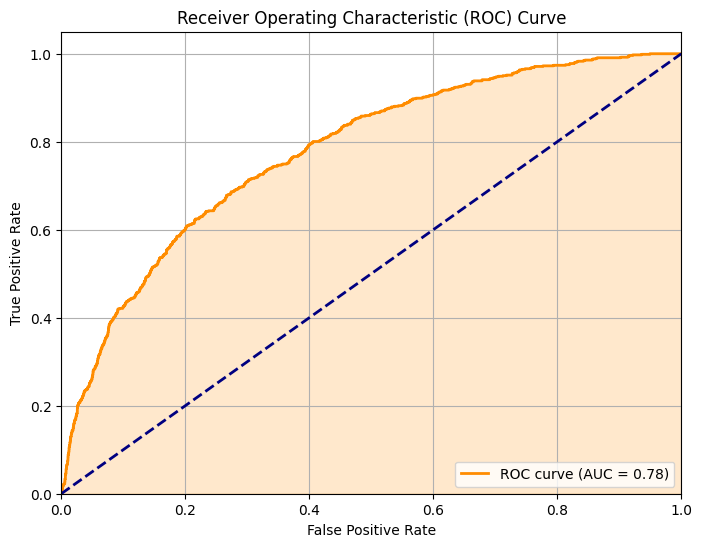

Precision-Recall curve saved as precision_recall_curve_gene_split.png


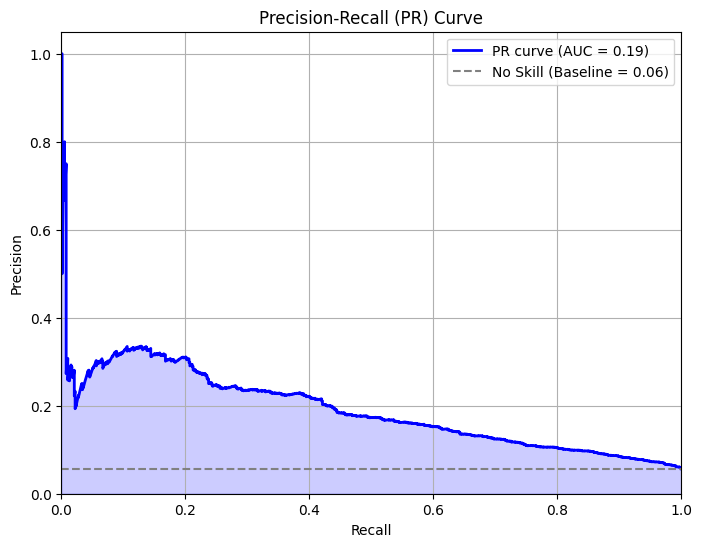


Feature Importances:
mpc_score_api                 0.162027
deogen2_score_api             0.148564
Expression_value              0.127852
bstatistic_score_api          0.091276
fathmm_score_api              0.079738
mvp_score_api                 0.077987
provean_score_api             0.070183
m_cap_score_api               0.065505
mutationassessor_score_api    0.065321
polyphen2_hdiv_score_api      0.057708
CNA_value                     0.053839
dtype: float32
Feature importances plot saved as feature_importances_gene_split.png


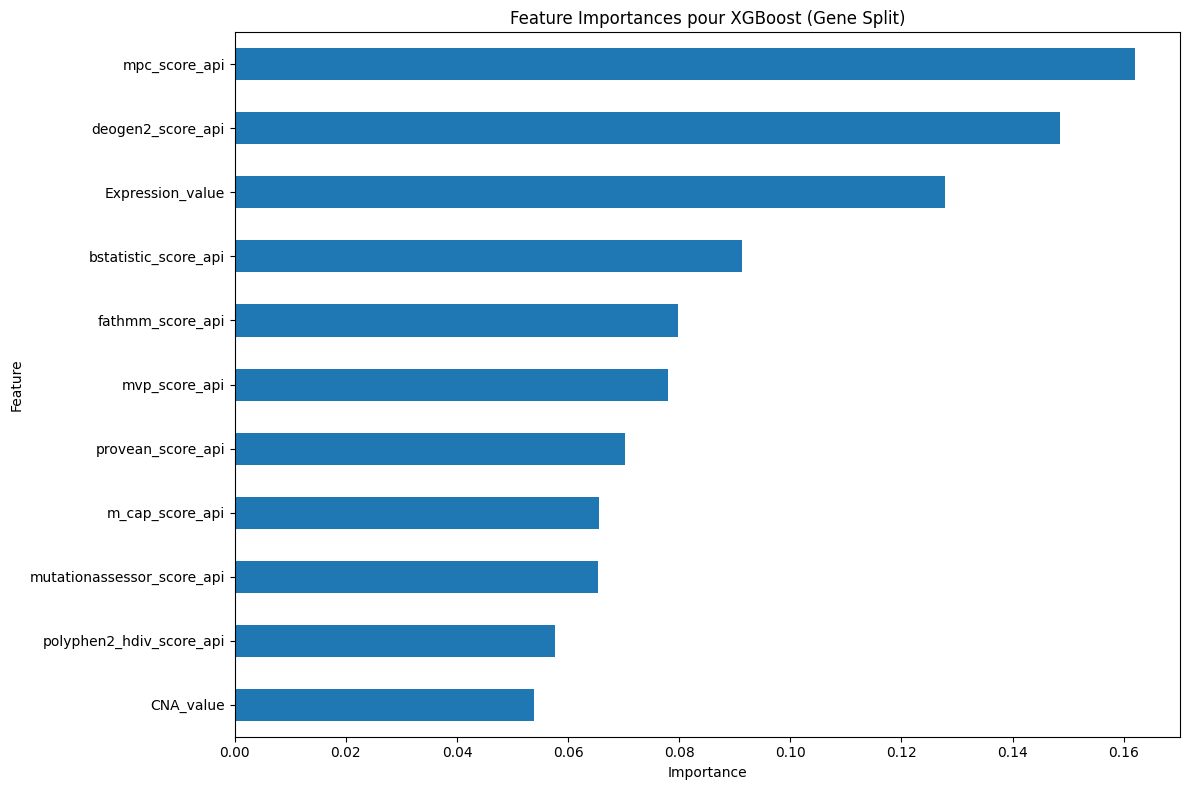


--- Script terminé ---


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, roc_auc_score
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer

print("\n--- 4. Sélection et Prétraitement des Caractéristiques ---")

feature_columns = []

if 'SIFT' in mutations_df.columns:
    sift_scores_str = mutations_df['SIFT'].astype(str).apply(
        lambda x: re.search(r'\((.*?)\)', x).group(1) if pd.notna(x) and re.search(r'\((.*?)\)', x) else None)
    mutations_df['SIFT_score_maf'] = pd.to_numeric(sift_scores_str, errors='coerce')
    sift_pred_map = {'deleterious': 1, 'deleterious_low_confidence': 1, 'tolerated': 0, 'tolerated_low_confidence': 0}
    sift_pred_mapped = mutations_df['SIFT'].astype(str).apply(
        lambda x: sift_pred_map.get(x.split('(')[0].lower().strip(), pd.NA) if pd.notna(x) and '(' in x else
                  sift_pred_map.get(x.lower().strip(), pd.NA) if pd.notna(x) else pd.NA)
    mutations_df['SIFT_pred_maf'] = pd.to_numeric(sift_pred_mapped, errors='coerce')
    if not mutations_df['SIFT_score_maf'].isnull().all(): feature_columns.append('SIFT_score_maf')
    if not mutations_df['SIFT_pred_maf'].isnull().all(): feature_columns.append('SIFT_pred_maf')

if 'PolyPhen' in mutations_df.columns:
    polyphen_scores_str = mutations_df['PolyPhen'].astype(str).apply(
        lambda x: re.search(r'\((.*?)\)', x).group(1) if pd.notna(x) and re.search(r'\((.*?)\)', x) else None)
    mutations_df['PolyPhen_score_maf'] = pd.to_numeric(polyphen_scores_str, errors='coerce')
    polyphen_pred_map = {'probably_damaging': 2, 'possibly_damaging': 1, 'benign': 0, 'unknown': pd.NA}
    polyphen_pred_mapped = mutations_df['PolyPhen'].astype(str).apply(
        lambda x: polyphen_pred_map.get(x.split('(')[0].lower().strip(), pd.NA) if pd.notna(x) and '(' in x else
                  polyphen_pred_map.get(x.lower().strip(), pd.NA) if pd.notna(x) else pd.NA)
    mutations_df['PolyPhen_pred_maf'] = pd.to_numeric(polyphen_pred_mapped, errors='coerce')
    if not mutations_df['PolyPhen_score_maf'].isnull().all(): feature_columns.append('PolyPhen_score_maf')
    if not mutations_df['PolyPhen_pred_maf'].isnull().all(): feature_columns.append('PolyPhen_pred_maf')

if 'Score' in mutations_df.columns:
    mutations_df['Generic_Score_maf'] = pd.to_numeric(mutations_df['Score'], errors='coerce')
    if not mutations_df['Generic_Score_maf'].isnull().all(): feature_columns.append('Generic_Score_maf')

if 'IMPACT' in mutations_df.columns:
    impact_map = {'HIGH': 3, 'MODERATE': 2, 'LOW': 1, 'MODIFIER': 0}
    mutations_df['IMPACT_numeric_maf'] = mutations_df['IMPACT'].map(impact_map)
    if not mutations_df['IMPACT_numeric_maf'].isnull().all() : feature_columns.append('IMPACT_numeric_maf')

if 'CNA_value' in mutations_df.columns:
    mutations_df['CNA_value'] = pd.to_numeric(mutations_df['CNA_value'], errors='coerce')
    if not mutations_df['CNA_value'].isnull().all(): feature_columns.append('CNA_value')

if 'Expression_value' in mutations_df.columns:
    mutations_df['Expression_value'] = pd.to_numeric(mutations_df['Expression_value'], errors='coerce')
    if not mutations_df['Expression_value'].isnull().all(): feature_columns.append('Expression_value')

api_score_cols_to_use = [
    'CADD_phred_api', 'CADD_raw_api', 'sift_score_api', 'polyphen2_hvar_score_api',
    'polyphen2_hdiv_score_api', 'revel_score_api', 'metalr_score_api', 'metasvm_score_api',
    'mutationassessor_score_api', 'mutationtaster_score_api', 'provean_score_api',
    'fathmm_score_api', 'fathmm_mkl_coding_score_api', 'm_cap_score_api', 'deogen2_score_api',
    'mvp_score_api', 'mpc_score_api', 'clinpred_score_api', 'list_s2_score_api',
    'alphamissense_score_api', 'gerp++_rs_api', 'bstatistic_score_api'
]

for col_name in api_score_cols_to_use:
    if col_name in mutations_df.columns:
        mutations_df[col_name] = pd.to_numeric(mutations_df[col_name], errors='coerce')
        if not mutations_df[col_name].isnull().all():
            feature_columns.append(col_name)
    else:
        print(f"   AVERTISSEMENT: Colonne de score API '{col_name}' attendue mais non trouvée dans mutations_df.")

feature_columns = sorted(list(set(feature_columns)))
feature_columns = [col for col in feature_columns if not "maf" in col]

sorted_by_importance = ["deogen2_score_api", "Expression_value", "mvp_score_api", "mpc_score_api", "m_cap_score_api", "provean_score_api", "fathmm_score_api", "mutationassessor_score_api", "CNA_value", "bstatistic_score_api", "polyphen2_hdiv_score_api", "gerp++_rs_api", "metalr_score_api", "clinpred_score_api", "metasvm_score_api", "list_s2_score_api", "fathmm_mkl_coding_score_api", "polyphen2_hvar_score_api", "alphamissense_score_api", "sift_score_api", "mutationtaster_score_api", "CADD_phred_api", "revel_score_api"]
present_sorted_features = [f for f in sorted_by_importance if f in mutations_df.columns and f in feature_columns]
top_n = 11
top_features = present_sorted_features[:top_n]

if 'Expression_value' in mutations_df.columns and 'Expression_value' in feature_columns:
    if 'Expression_value' not in top_features : top_features.append('Expression_value')
if 'CNA_value' in mutations_df.columns and 'CNA_value' in feature_columns:
    if 'CNA_value' not in top_features : top_features.append('CNA_value')

top_features = sorted(list(set(top_features)))
print(f"\nColonnes de features finales utilisées pour X: {top_features}")

if not top_features:
    print("AVERTISSEMENT CRITIQUE : Aucune feature utilisable sélectionnée dans top_features. Arrêt.")
    exit()

print("\n--- Division des données basée sur les gènes pour l'entraînement et le test ---")

present_hugo_symbols = mutations_df['Hugo_Symbol'].unique()
driver_genes_in_data = sorted(list(set(present_hugo_symbols) & set(known_cancer_genes)))

if not driver_genes_in_data:
    print("AVERTISSEMENT CRITIQUE : Aucun gène 'driver' connu n'a été trouvé dans les données fournies (mutations_df). Impossible de continuer.")
    exit()

if len(driver_genes_in_data) < 2:
    print(f"AVERTISSEMENT : Moins de 2 gènes 'driver' uniques ({len(driver_genes_in_data)}) présents dans les données. "
          "Tous les gènes drivers seront utilisés pour l'entraînement. L'évaluation de la découverte de 'nouveaux' gènes sera limitée.")
    train_driver_genes = driver_genes_in_data[:]
    test_driver_genes = []
else:
    train_driver_genes, test_driver_genes = train_test_split(
        driver_genes_in_data,
        test_size=0.2,
        random_state=42
    )
    if not test_driver_genes:
        print("AVERTISSEMENT: Aucun gène driver n'a été assigné à l'ensemble de test après la division. "
              "Tous les gènes drivers connus sont dans l'ensemble d'entraînement.")
    if not train_driver_genes:
        print("AVERTISSEMENT CRITIQUE: Aucun gène driver n'a été assigné à l'ensemble d'entraînement. Le modèle ne sera pas entraîné sur des exemples de drivers.")


print(f"Nombre de gènes 'driver' pour l'entraînement: {len(train_driver_genes)}")
if train_driver_genes: print(f"Exemples de gènes drivers d'entraînement: {train_driver_genes[:min(5, len(train_driver_genes))]}")

print(f"Nombre de gènes 'driver' pour le test (considérés 'nouveaux'): {len(test_driver_genes)}")
if test_driver_genes: print(f"Exemples de gènes drivers de test: {test_driver_genes[:min(5, len(test_driver_genes))]}")


train_driver_mutation_indices = mutations_df[mutations_df['Hugo_Symbol'].isin(train_driver_genes)].index
test_driver_mutation_indices = mutations_df[mutations_df['Hugo_Symbol'].isin(test_driver_genes)].index
passenger_mutation_indices = mutations_df[~mutations_df['Hugo_Symbol'].isin(known_cancer_genes)].index

X_all = mutations_df[top_features].copy()
y_ground_truth = mutations_df['Hugo_Symbol'].isin(known_cancer_genes).astype(int)

if passenger_mutation_indices.empty:
    print("AVERTISSEMENT: Aucune mutation 'passenger' à diviser.")
    passenger_train_indices = pd.Index([])
    passenger_test_indices = pd.Index([])
elif len(passenger_mutation_indices) < 2:
    print(f"AVERTISSEMENT: Nombre insuffisant de mutations 'passenger' ({len(passenger_mutation_indices)}) pour un split. "
          "Toutes les mutations passenger iront dans l'ensemble d'entraînement.")
    passenger_train_indices = passenger_mutation_indices[:]
    passenger_test_indices = pd.Index([])
else:
    passenger_train_indices, passenger_test_indices = train_test_split(
        passenger_mutation_indices,
        test_size=0.2,
        random_state=42,
    )

train_indices = train_driver_mutation_indices.union(passenger_train_indices)
test_indices = test_driver_mutation_indices.union(passenger_test_indices)

common_indices = train_indices.intersection(test_indices)
if not common_indices.empty:
    print(f"AVERTISSEMENT CRITIQUE: {len(common_indices)} mutations sont communes aux ensembles d'entraînement et de test. Vérifiez la logique de division.")

if train_indices.empty:
    print("AVERTISSEMENT CRITIQUE : L'ensemble d'entraînement (train_indices) est vide. Arrêt.")
    exit()
if test_indices.empty:
    print("AVERTISSEMENT : L'ensemble de test (test_indices) est vide. L'évaluation du modèle ne sera pas possible.")

X_train = X_all.loc[train_indices].copy()
y_train = y_ground_truth.loc[train_indices].copy()
X_test = X_all.loc[test_indices].copy() if not test_indices.empty else pd.DataFrame(columns=top_features)
y_test = y_ground_truth.loc[test_indices].copy() if not test_indices.empty else pd.Series(dtype=int)


print(f"Taille de l'ensemble d'entraînement final: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Distribution des classes dans y_train: {y_train.value_counts().to_dict()}")
print(f"Taille de l'ensemble de test final: X_test {X_test.shape}, y_test {y_test.shape}")
if not y_test.empty:
    print(f"Distribution des classes dans y_test: {y_test.value_counts().to_dict()}")
else:
    print("y_test est vide.")


print("\n--- 7. Imputation des valeurs manquantes ---")
if X_train.empty:
    print("X_train est vide AVANT imputation. Impossible de continuer.")
    exit()

needs_imputation_train = X_train.isnull().values.any()
needs_imputation_test = (not X_test.empty) and X_test.isnull().values.any()

if needs_imputation_train or needs_imputation_test:
    print("Valeurs manquantes détectées. Imputation avec la médiane (calculée sur X_train)...")
    imputer = SimpleImputer(strategy='median')

    X_train_cols = X_train.columns
    X_train_idx = X_train.index
    X_test_cols = X_test.columns
    X_test_idx = X_test.index

    X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train_cols, index=X_train_idx)

    if not X_test.empty:
        if X_test.isnull().values.any():
            X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test_cols, index=X_test_idx)
    else:
        print("X_test est vide, pas d'imputation pour X_test.")
    print("Imputation terminée.")

    if X_train.isnull().values.any():
        print("ATTENTION: Encore des valeurs manquantes dans X_train après imputation avec la médiane. Remplacement par 0...")
        X_train = X_train.fillna(0)
    if not X_test.empty and X_test.isnull().values.any():
        print("ATTENTION: Encore des valeurs manquantes dans X_test après imputation avec la médiane. Remplacement par 0...")
        X_test = X_test.fillna(0)
else:
    print("Aucune valeur manquante ne nécessitant imputation dans X_train (et X_test si non vide).")


print("\n--- 5. Entraînement et Évaluation du Modèle ---")

if X_train.shape[0] < 2 or y_train.shape[0] < 2 or X_train.shape[0] != y_train.shape[0]:
    print("Pas assez de données dans l'ensemble d'entraînement ou incohérence de taille. Arrêt.")
    exit()

min_samples_per_class = 1
y_train_value_counts = y_train.value_counts()

if len(y_train_value_counts) < 2 :
    print(f"AVERTISSEMENT CRITIQUE : Moins de deux classes présentes dans y_train ({y_train_value_counts.to_dict()}). XGBoost nécessite au moins deux classes pour 'binary:logistic'. Arrêt.")
    exit()
if y_train_value_counts.min() < min_samples_per_class :
    print(f"AVERTISSEMENT CRITIQUE : Pas assez d'échantillons pour au moins une classe dans y_train (min {min_samples_per_class} requis, trouvé: {y_train_value_counts.to_dict()}). Arrêt.")
    exit()


y_train_counts_bincount = np.bincount(y_train)
if len(y_train_counts_bincount) < 2:
    print("AVERTISSEMENT CRITIQUE : Une seule classe est présente dans y_train après le split (vérification bincount). Arrêt.")
    exit()

if y_train_counts_bincount[0] == 0 or y_train_counts_bincount[1] == 0:
    print("AVERTISSEMENT CRITIQUE : Au moins une classe est absente ou a zéro échantillon dans y_train (vérification bincount). Arrêt.")
    exit()
else:
    scale_pos_weight = y_train_counts_bincount[0] / y_train_counts_bincount[1]
    print(f"Calcul de scale_pos_weight pour XGBoost: {scale_pos_weight:.4f}")

model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)

if X_train.empty:
    print("X_train est vide. Impossible d'entraîner le modèle.")
else:
    model.fit(X_train, y_train)

    if X_test.empty or y_test.empty:
        print("\nEnsemble de test (X_test ou y_test) est vide. L'évaluation du modèle est ignorée.")
        y_pred = np.array([])
        y_pred_proba = np.array([])
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        print("\n--- Évaluation du Modèle sur l'ensemble de test ---")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

        auc_roc_val = -1
        auc_pr_val = -1
        precision = None
        recall = None

        if len(np.unique(y_test)) > 1:
            auc_roc_val = roc_auc_score(y_test, y_pred_proba)
            print(f"AUC-ROC: {auc_roc_val:.4f}")
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            auc_pr_val = auc(recall, precision)
            print(f"AUC-PR: {auc_pr_val:.4f}")
        else:
            print("Une seule classe (ou aucune) présente dans y_test. Calcul des AUCs et des courbes ROC/PR non significatif ou impossible.")

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, zero_division=0))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        if len(np.unique(y_test)) > 1 and y_pred_proba is not None and len(y_pred_proba) > 0:
            fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc_val:.2f})')
            plt.fill_between(fpr, tpr, color='darkorange', alpha=0.2)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.grid(True)
            plt.savefig('roc_curve_gene_split_discover_genes.png')
            print("\nROC curve saved as roc_curve_gene_split.png")
            plt.show()

            if precision is not None and recall is not None:
                plt.figure(figsize=(8, 6))
                plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {auc_pr_val:.2f})')
                plt.fill_between(recall, precision, step='post', alpha=0.2, color='blue')


                no_skill_level = y_test.sum() / len(y_test) if len(y_test) > 0 else 0
                plt.plot([0, 1], [no_skill_level, no_skill_level], linestyle='--', color='gray', label=f'No Skill (Baseline = {no_skill_level:.2f})')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.ylim([0.0, 1.05])
                plt.xlim([0.0, 1.0])
                plt.title('Precision-Recall (PR) Curve')
                plt.legend(loc="best")
                plt.grid(True)
                plt.savefig('precision_recall_curve_gene_split_discover_genes.png')
                print("Precision-Recall curve saved as precision_recall_curve_gene_split.png")
                plt.show()
        else:
            print("Visualisation des courbes ROC/PR ignorée car y_test ne contient pas les deux classes ou y_pred_proba est manquant.")


    if hasattr(model, 'feature_importances_') and not X_train.empty :
        try:
            feature_importances_df = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            print("\nFeature Importances:")
            print(feature_importances_df)

            plt.figure(figsize=(12, max(8, len(X_train.columns) * 0.3)))
            feature_importances_df.plot(kind='barh')
            plt.title('Feature Importances pour XGBoost (Gene Split)')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importances_gene_split.png')
            print("Feature importances plot saved as feature_importances_gene_split.png")
            plt.show()
        except Exception as e:
            print(f"Erreur lors de l'affichage/visualisation des feature importances: {e}")

print("\n--- Script terminé ---")